# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [192]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [193]:
from common_utils import MLP, split_dataset, preprocess_dataset, CustomDataset, loss_fn
import pandas as pd

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += ((pred > 0.5).type(torch.float) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    print(f"Train Error: \n Accuracy: {(correct*100):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    
    return train_loss, correct

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += ((pred > 0.5).type(torch.float) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, correct

def preprocess(df):
    
    X_train, y_train, X_test, y_test = split_dataset(df,['filename','label'],0.3,0)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

train_data = CustomDataset(X_train_scaled, y_train)
test_data = CustomDataset(X_test_scaled, y_test)


3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [194]:
from common_utils import EarlyStopper

def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):

    train_data = CustomDataset(X_train_scaled, y_train2)
    val_data = CustomDataset(X_val_scaled, y_val2)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    early_stopper = EarlyStopper(patience=3, min_delta=0)

    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []

    times = []

    for t in range(100):
        print(f"Epoch {t+1}\n-------------------------------")
        
        # Training Loop
        start = time.time()
        train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)

        # Saving train accuracy and loss for each epoch
        train_accuracies.append(train_acc), train_losses.append(train_loss)
        end = time.time()

        # Saving time take for each epoch
        times.append(end-start)

        # Validation Loop        
        test_loss, test_acc = test_loop(val_dataloader, model, loss_fn)

        # Saving test accuracy and loss for each epoch
        test_accuracies.append(test_acc), test_losses.append(test_loss)

        if early_stopper.early_stop(test_loss):
            print("Early stopping")
            break

    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [195]:
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    cross_validation_accuracies = []
    cross_validation_times = []

    for parameter in parameters:
        print(f"Parameter {parameter}")
        accuracies = []
        times = []
        for train_index, val_index in kf.split(X_train):
            X_train2, X_val2 = X_train[train_index], X_train[val_index]
            y_train2, y_val2 = y_train[train_index], y_train[val_index]

            model = MLP(77,parameter,1)

            train_accuracies, train_losses, test_accuracies, test_losses, time = train(model, X_train2, y_train2, X_val2, y_val2, batch_size)
            
            # Save the accuracy for each fold at the last epoch
            accuracies.append(test_accuracies[-1])
            
            # Save the time taken to train for each fold at the last epoch
            times.append(time[-1])
            
        # Mean Accuracy for the Number of Neurons (Mean of Accuracy at Last Epoch for each Fold)
        cross_validation_accuracies.append(np.mean(accuracies))

        # Mean Time taken for the Number of Neurons (Mean of Time at Last Epoch for each Fold)
        cross_validation_times.append(np.mean(times))

    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 256. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE
optimal_bs = 256
num_neurons = [64,128,256]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled, y_train, num_neurons, 'num_neurons', optimal_bs)

Parameter 64
Epoch 1
-------------------------------
loss: 0.693020  [  256/ 6751]
Train Error: 
 Accuracy: 52.9%, Avg loss: 0.690763 

Test Error: 
 Accuracy: 57.6%, Avg loss: 0.683927 

Epoch 2
-------------------------------
loss: 0.685569  [  256/ 6751]
Train Error: 
 Accuracy: 56.5%, Avg loss: 0.682004 

Test Error: 
 Accuracy: 57.5%, Avg loss: 0.672667 

Epoch 3
-------------------------------
loss: 0.671673  [  256/ 6751]
Train Error: 
 Accuracy: 58.9%, Avg loss: 0.672047 

Test Error: 
 Accuracy: 59.2%, Avg loss: 0.663822 

Epoch 4
-------------------------------
loss: 0.676243  [  256/ 6751]
Train Error: 
 Accuracy: 59.8%, Avg loss: 0.662899 

Test Error: 
 Accuracy: 60.8%, Avg loss: 0.659915 

Epoch 5
-------------------------------
loss: 0.657733  [  256/ 6751]
Train Error: 
 Accuracy: 60.7%, Avg loss: 0.656043 

Test Error: 
 Accuracy: 62.2%, Avg loss: 0.648927 

Epoch 6
-------------------------------
loss: 0.664692  [  256/ 6751]
Train Error: 
 Accuracy: 61.7%, Avg loss: 

4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

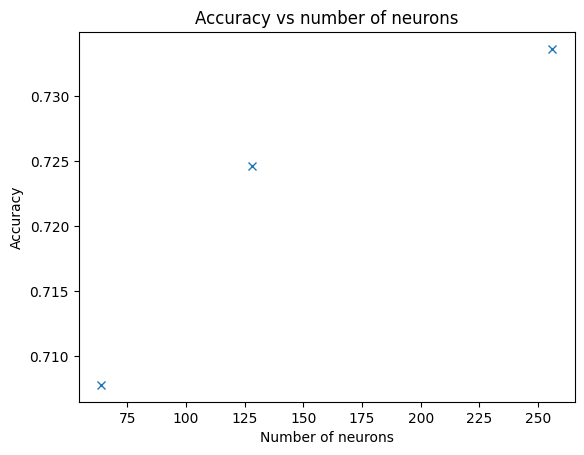

In [196]:
plt.plot(num_neurons, cross_validation_accuracies, marker='x', linestyle='None')
plt.xlabel('Number of neurons')
plt.ylabel('Accuracy')
plt.title('Accuracy vs number of neurons')
plt.show()

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [197]:
df = pd.DataFrame({'First Hidden-Layer Neurons': num_neurons,
                   'Last Epoch Time': cross_validation_times,
                   'Cross Validation Accuracy': cross_validation_accuracies                   
                  })
df

,First Hidden-Layer Neurons,Last Epoch Time,Cross Validation Accuracy
0,64,0.049714,0.707789
1,128,0.070154,0.724614
2,256,0.070359,0.733619


In [198]:
# Sort df by Last Epoch Time and create a column measuring the percentage difference between each

last_epoch_df = df.sort_values(by=['Last Epoch Time'], ascending=False)
last_epoch_df['Percentage Difference from previous Last Epoch Time'] = last_epoch_df['Last Epoch Time'].pct_change()*100
last_epoch_df

,First Hidden-Layer Neurons,Last Epoch Time,Cross Validation Accuracy,Percentage Difference from previous Last Epoch Time
2,256,0.070359,0.733619,NaN
1,128,0.070154,0.724614,-0.292231
0,64,0.049714,0.707789,-29.135805


In [199]:
# Sort df by Cross Validation Accuracy and create a column measuring the percentage difference between each

cv_df = df.sort_values(by=['Cross Validation Accuracy'], ascending=False)
cv_df['Percentage Difference from previous Cross Validation Accuracy'] = cv_df['Cross Validation Accuracy'].pct_change()*100
cv_df

,First Hidden-Layer Neurons,Last Epoch Time,Cross Validation Accuracy,Percentage Difference from previous Cross Validation Accuracy
2,256,0.070359,0.733619,NaN
1,128,0.070154,0.724614,-1.227507
0,64,0.049714,0.707789,-2.321993


In [200]:
optimal_neurons = 256
reason = "We take 256 as Optimal Neurons as the 7-10% time saved does not justify the accuracy lost."

6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

In [201]:
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

In [202]:
input_features = X_train_scaled.shape[1]
no_labels = 1
final_model = MLP(input_features,optimal_neurons,no_labels)
optimal_bs = 256

train_accuracies, train_losses, test_accuracies, test_losses, times = train(final_model, X_train_scaled, y_train, X_test_scaled, y_test, optimal_bs)

# save the model
torch.save(final_model.state_dict(), 'model.pt')

Epoch 1
-------------------------------
loss: 0.696786  [  256/ 8439]
Train Error: 
 Accuracy: 54.0%, Avg loss: 0.687120 

Test Error: 
 Accuracy: 57.2%, Avg loss: 0.677571 

Epoch 2
-------------------------------
loss: 0.668669  [  256/ 8439]
Train Error: 
 Accuracy: 58.8%, Avg loss: 0.670185 

Test Error: 
 Accuracy: 59.7%, Avg loss: 0.662794 

Epoch 3
-------------------------------
loss: 0.637318  [  256/ 8439]
Train Error: 
 Accuracy: 61.9%, Avg loss: 0.649865 

Test Error: 
 Accuracy: 62.0%, Avg loss: 0.654203 

Epoch 4
-------------------------------
loss: 0.646508  [  256/ 8439]
Train Error: 
 Accuracy: 63.4%, Avg loss: 0.633521 

Test Error: 
 Accuracy: 63.7%, Avg loss: 0.630264 

Epoch 5
-------------------------------
loss: 0.623259  [  256/ 8439]
Train Error: 
 Accuracy: 66.0%, Avg loss: 0.613430 

Test Error: 
 Accuracy: 65.3%, Avg loss: 0.621562 

Epoch 6
-------------------------------
loss: 0.587030  [  256/ 8439]
Train Error: 
 Accuracy: 68.2%, Avg loss: 0.596934 

Te

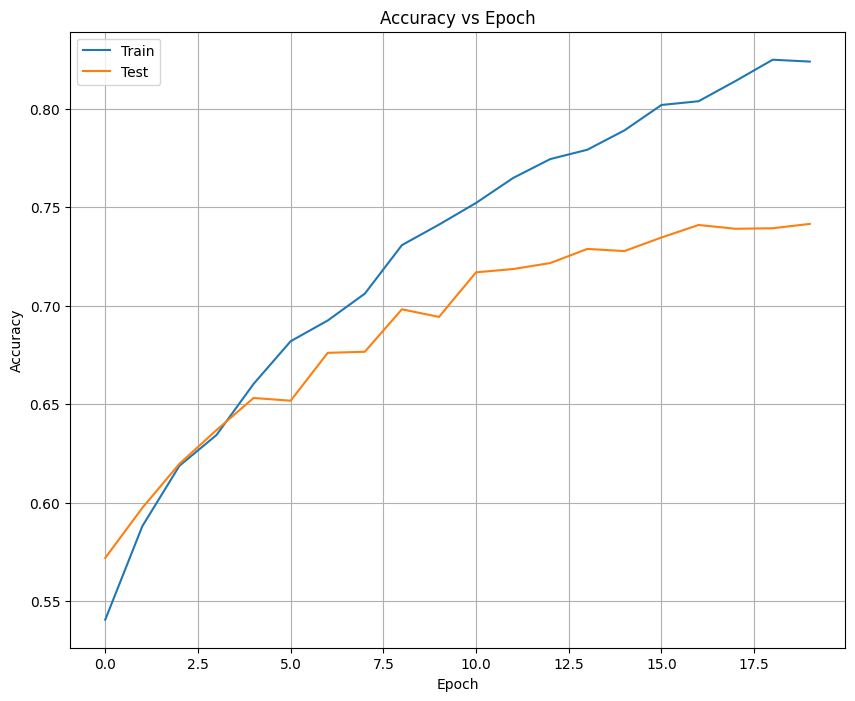

In [203]:
# YOUR CODE HERE
plt.figure(figsize=(10,8))
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.grid(True)
plt.legend()